# ION CHANNEL DETECTION // DENOISING 1D TIME SIGNAL

## KAGGLE INTRODUCTION

Many diseases, including cancer, are believed to have a contributing factor in common. Ion channels are pore-forming proteins present in animals and plants. They encode learning and memory, help fight infections, enable pain signals, and stimulate muscle contraction. If scientists could better study ion channels, which may be possible with the aid of machine learning, it could have a far-reaching impact.



When ion channels open, they pass electric currents. Existing methods of detecting these state changes are slow and laborious. Humans must supervise the analysis, which imparts considerable bias, in addition to being tedious. These difficulties limit the volume of ion channel current analysis that can be used in research. Scientists hope that technology could enable rapid automatic detection of ion channel current events in raw data.

The University of Liverpool’s Institute of Ageing and Chronic Disease is working to advance ion channel research. Their team of scientists have asked for your help. In this competition, you’ll use ion channel data to better model automatic identification methods. If successful, you’ll be able to detect individual ion channel events in noisy raw signals. The data is simulated and injected with real world noise to emulate what scientists observe in laboratory experiments.

Technology to analyze electrical data in cells has not changed significantly over the past 20 years. If we better understand ion channel activity, the research could impact many areas related to cell health and migration. From human diseases to how climate change affects plants, faster detection of ion channels could greatly accelerate solutions to major world problems.

## IMPORT LIBRARIES

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math as math
import tensorflow_addons as tfa
from tqdm.auto import tqdm
from sklearn.metrics import cohen_kappa_score, f1_score
from tensorflow.keras.callbacks import Callback
from pykalman import KalmanFilter

## DATA

**train.csv**: contains three columns [time, signal, open_channels]. 10 data series are provided, the length of each serie is 500000, which comprise 50 seconds. The file provides the 10 series consecutively. This is first series goes from [0:499999], the second [500000:999999],... The maximum number of channels open is 10, hence, there are 11 possible outputs 0..10. Added to the signal, there is random noise and different forms of drift.

**test.csv**: contains two columns [time, signal]. It contains 4 data series similar to the ones found in training data.

Notice that not all the series have 10 channels, only 4 and 9. While noise appear in all the signals, drif only appears in series 1 and 6 to 9.

When it is observed a x-y plot, it is clear that there is not a direct relation between them. At any time, the state of the ion channels depends only on the previous state through a Markov stochastic model. Check more detail on the data generation in: [**Deep-Channel uses deep neural networks to detect
single-molecule events from patch-clamp data**](https://www.nature.com/articles/s42003-019-0729-3).

To improve results, it can be used a pre-cleaned data from [Chris Deotte](https://www.kaggle.com/cdeotte/data-without-drift)


In [2]:
## Path to data folder
PATH_DATA = "Data/"
PATH_RESULTS='Results/'

In [3]:
## Downloading labels
df = pd.read_csv(PATH_DATA+"train_clean.csv")  # Pre-cleaned data
## df = pd.read_csv(PATH_DATA+"train.csv")
x=np.array(df.iloc[:,1]).reshape(-1,1)
y=np.array(df.iloc[:,2]).reshape(-1,1)
y_s=y # y_sparse
y=tf.one_hot(y,11).numpy()
del df

print("Shape of label matrix y is: (%d,%d,%d)" %y.shape)
print("Shape of label matrix x is: (%d,%d)" %x.shape)

Shape of label matrix y is: (5000000,1,11)
Shape of label matrix x is: (5000000,1)


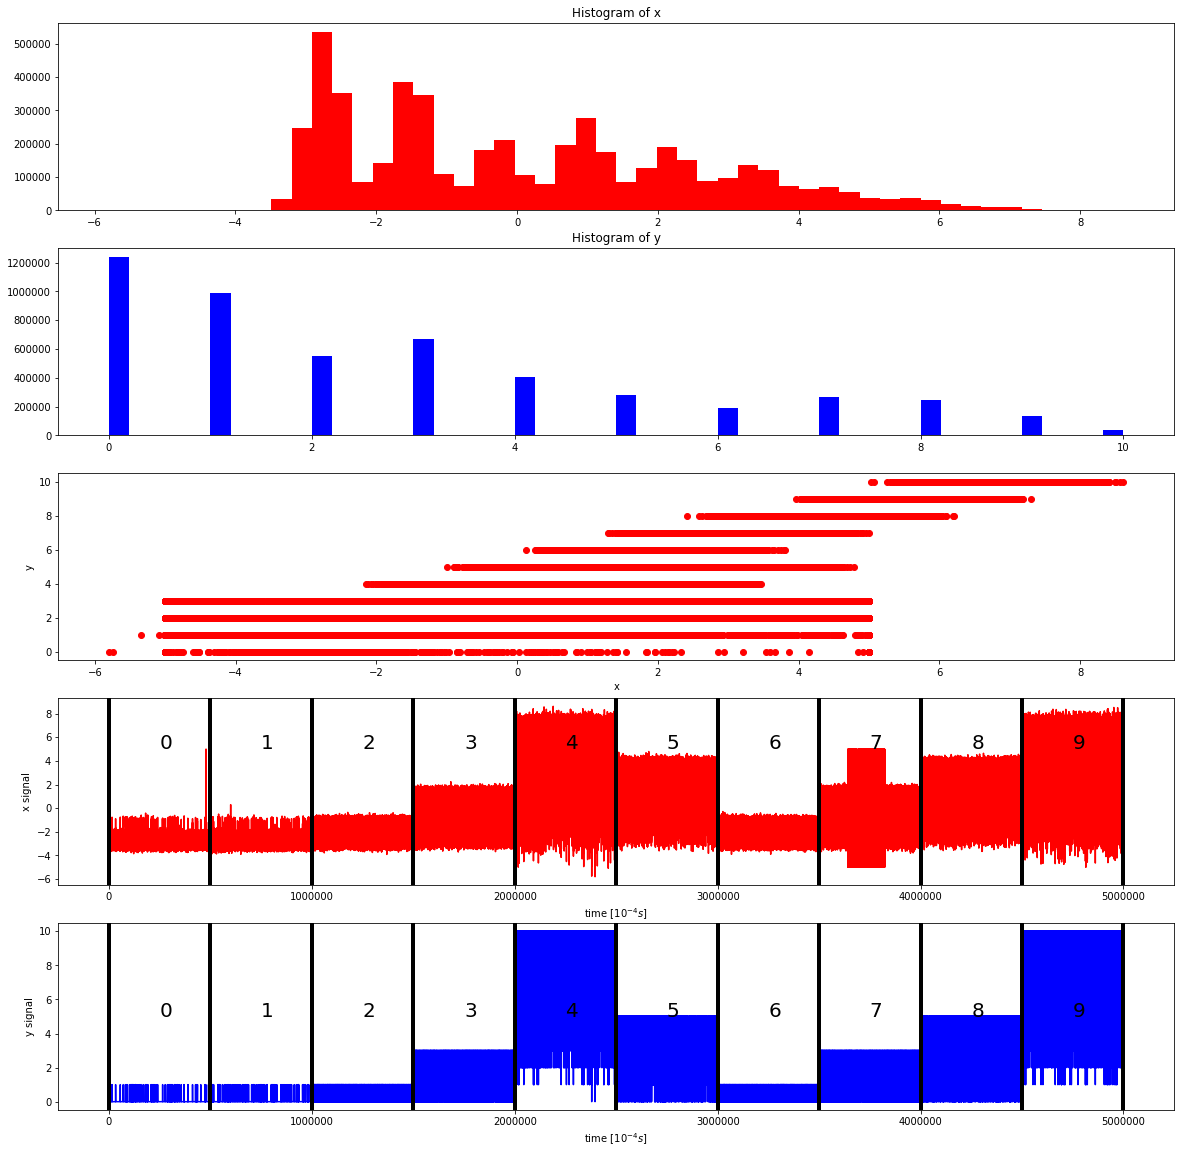

In [4]:
plt.figure(figsize=(20,20))
plt.subplot(511)
plt.hist(x, bins=50,color='red')
plt.title('Histogram of x')
plt.subplot(512)
plt.hist(y_s, bins=50,color='blue')
plt.title('Histogram of y')
plt.subplot(513)
plt.scatter(x,y_s,color='red')
plt.ylabel('y')
plt.xlabel('x')
plt.subplot(514)
plt.plot(np.arange(x.shape[0]),x,color='red')
for i in range(10):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*10,linewidth=4, color='black')
plt.ylabel('x signal')
plt.xlabel('time [$10^{-4} s$]')
plt.subplot(515)
plt.plot(np.arange(y_s.shape[0]),y_s,color='blue')
for i in range(10):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*10,linewidth=4, color='black')
plt.ylabel('y signal')
plt.xlabel('time [$10^{-4} s$]')
plt.show()

## Pre-processing

Low pass filter to remove drift.

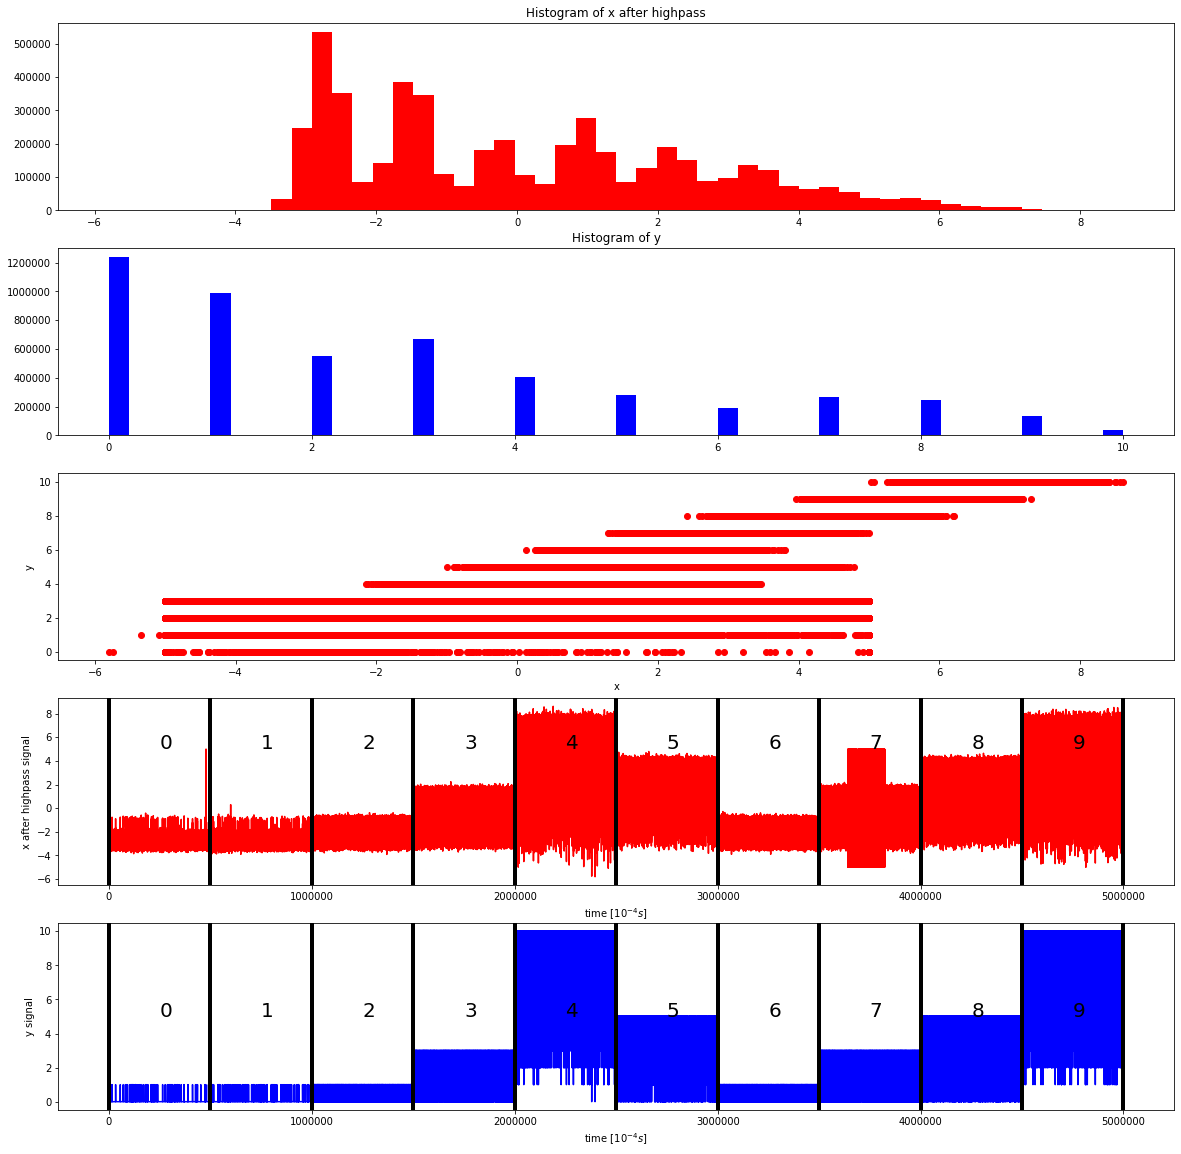

In [5]:
def HighPassfilter(x,harmonic,batch,removebias=1, Kalman=0):
    ## INPUTS:
    # x: numpy array to remove low harmonics
    # harmonic: number of harmonics to remove
    # batch: x is batched before fft, before the output is flattened.
    # removebias: remove constant element from fft
    # Kalman: Apply Kalman filter if Kalman==1
    ## OUTPUTS:
    # x: numpy array flattened after high pass filter
    
    x=x.reshape(batch,-1)
    xf=np.fft.fft(x)
    if removebias==1:
        xf[:,0]=0
    xf[:,1:harmonic+1]=0
    xf[:,-harmonic:]=0    
    x=np.real(np.fft.ifft(xf))
    ## Kalman Filter 
    if Kalman==1:
        for i in range(batch):
            print('batch: ', i)
            kf=KalmanFilter(transition_matrices=1,
                            observation_matrices=1,
                            transition_covariance=0.1,
                            observation_covariance=0.0015,
                            transition_offsets=0,
                            observation_offsets=0,
                            initial_state_mean=x[i,0],
                            initial_state_covariance=1)
            X_smooth=kf.smooth(x[i,:])
            X_smooth=X_smooth[0].reshape(1,-1)
            x[i,:]=X_smooth
        
    return x.reshape(-1,1)

HARMONICS=100
BATCHHARM=10
REMOVEBIAS=1
NCHANNELX=1

## If original data is used, use the high pass filter
#xfft=HighPassfilter(x,HARMONICS,BATCHHARM,REMOVEBIAS,Kalman=0)
## If the cleaned data is used, the simply:
xfft=x

plt.figure(figsize=(20,20))
plt.subplot(511)
plt.hist(xfft, bins=50,color='red')
plt.title('Histogram of x after highpass')
plt.subplot(512)
plt.hist(y_s, bins=50,color='blue')
plt.title('Histogram of y')
plt.subplot(513)
plt.scatter(xfft,y_s,color='red')
plt.ylabel('y')
plt.xlabel('x')
plt.subplot(514)
plt.plot(np.arange(xfft.shape[0]),xfft,color='red')
for i in range(10):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*10,linewidth=4, color='black')
plt.ylabel('x after highpass signal')
plt.xlabel('time [$10^{-4} s$]')
plt.subplot(515)
plt.plot(np.arange(y_s.shape[0]),y_s,color='blue')
for i in range(10):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*10,linewidth=4, color='black')
plt.ylabel('y signal')
plt.xlabel('time [$10^{-4} s$]')
plt.show()


**Dividing data in training and cross-validration (CV)**

Since there is less data on the series with 10 channels, it seems important to assure that these two series (4 and 9) are present in both test and CV in the correct proportion.

In [6]:
def divide_data(X,Y,nn,batch_original,size,ChannelY_output,CrossValidationProp=0.1,plot=0):
    ## INPUTS
    # X: 3D numpy array with x data
    # Y: 3D numpy array with y data in one-hot
    # nn: selected batches
    # size: desired size for model fitting
    # ChannelY_output: Number of channels in Y output (if it is desired to reduce the number of channels)
    # CrossValidationProp: proportion of data for cross-validation
    # plot: 1 for plotting info about the processing
    ## OUTPUTS
    # x_train: numpy array with x data for training. (batch_train,size,1)
    # x_CV: numpy array with x data for CV (batch_CV,size,1)
    # y_train: numpy array with y data in one-hot used for training (batch_train,size,ChannelY_output)
    # y_CV: numpy array with y data in one-hot used for CV (batch_CV,size,ChannelY_output)
    
    CHANNELS_X=X.shape[1]
    
    X=X.reshape(batch_original,-1,CHANNELS_X)
    X=X[nn,:,:]
    X=X.reshape(-1,size,CHANNELS_X)
    
    Y=Y.reshape(batch_original,-1,Y.shape[2])
    Y=Y[nn,:,:]
    Y=Y.reshape(-1,size,Y.shape[2])
    Y=Y[:,:,:ChannelY_output]
    
    x_train, x_CV, y_train, y_CV = train_test_split(X,Y, test_size=CrossValidationProp, random_state=1)
    if plot==1:
        print('x_train: (%d,%d,%d)' %(x_train.shape))
        print('x_CV: (%d,%d,%d)' %(x_CV.shape))
        print('y_train: (%d,%d,%d)' %(y_train.shape))
        print('y_CV: (%d,%d,%d)' %(y_CV.shape))
        print('size: %d' %size)
    return x_train, x_CV, y_train, y_CV

BATCH_SERIES=10
size=4000
NCHANNELY=11
CrossValidationProp=0.1
x_train11, x_CV11, y_train11, y_CV11=divide_data(xfft,y,[4,9],BATCH_SERIES,size,NCHANNELY,CrossValidationProp,plot=0)
x_train6, x_CV6, y_train6, y_CV6=divide_data(xfft,y,[0,1,2,3,5,6,7,8],BATCH_SERIES,size,NCHANNELY,CrossValidationProp,plot=0)

x_train=np.vstack([x_train11,x_train6])
y_train=np.vstack([y_train11,y_train6])
x_CV=np.vstack([x_CV11,x_CV6])
y_CV=np.vstack([y_CV11,y_CV6])

batch_train=x_train.shape[0]
batch_CV=x_CV.shape[0]

print('x_train shape: (%d,%d,%d)' %(x_train.shape))
print('x_CV shape: (%d,%d,%d)' %(x_CV.shape))
print('y_train shape: (%d,%d,%d)' %(y_train.shape))
print('y_CV shape: (%d,%d,%d)' %(y_CV.shape))

x_train shape: (1125,4000,1)
x_CV shape: (125,4000,1)
y_train shape: (1125,4000,11)
y_CV shape: (125,4000,11)


## DATAGEN

In [7]:
def augmentations(input_data, target_data):
    ## INPUTS
    # input_data  (x)
    # target_data (y)
    ## OUTPUTS
    # input_data  (x) reversed 50% of the time
    # target_data (y) reversed 50% of the time
    # Noise can be added, uncomment last line
    if np.random.rand()<0.5:    
        input_data = input_data[::-1]
        target_data = target_data[::-1]
    ## NOISE
    #input_data=input_data+np.random.rand(input_data.shape[0],1)*0.1
    return input_data, target_data

In [8]:
def Datagen(input_dataset, target_dataset, batch_size, is_train=False):
    ## DATAGEN FUNCTION.
    #  Returns batches of X and Y shuffled.
    ## INPUT:
    #  input_dataset: x
    #  target_dataset: y
    #  batch_size: batch size
    #  is_train: if True, augmentation function is applied
    
    x=[]
    y=[]
  
    count=0
    idx_1 = np.arange(len(input_dataset))
    np.random.shuffle(idx_1)

    while True:
        for i in range(len(input_dataset)):
            input_data = input_dataset[idx_1[i]]
            target_data = target_dataset[idx_1[i]]

            if is_train:
                input_data, target_data = augmentations(input_data, target_data)
                
            x.append(input_data)
            y.append(target_data)
            count+=1
            if count==batch_size:
                x=np.array(x, dtype=np.float32)
                y=np.array(y, dtype=np.float32)
                inputs = x
                targets = y       
                x = []
                y = []
                count=0
                yield inputs, targets

## MODEL

It is proposed to use a denoising autoencoder U-NET, using 1D convolutions. I thank the idea to [**K_mat (Kaggle)**](https://www.kaggle.com/kmat2019/u-net-1d-cnn-with-keras).

It shall be implemented a modification of [**LADDERNET**](https://arxiv.org/abs/1810.07810). The modifications respect to LADDERNET are:

(1) Use of RESNET or INCEPTIONRESNET as construction blocks

(2) blocks do not share weights

For U-NET read as well: [**U-NET: Convolutional Networks for Biomedical Image Segmentation**](https://arxiv.org/abs/1505.04597) with RESNET or INCEPTIONRESNET blocks.

Another approach which also uses 1D convolutions is using a WAVENET. The idea came from [**Siavash (Kaggle)**](https://www.kaggle.com/siavrez/wavenet-keras).

It was implemented a WAVENET based on [**A Wavenet for Speech Denoising**](https://arxiv.org/abs/1706.07162), [**WAVENET: A GENERATIVE MODEL FOR RAW AUDIO**](https://arxiv.org/abs/1609.03499).

In WAVENET model, it can be used either the residual either the skip connections to denoise the signal.



### UNIT DEFINITION

In [9]:
def convbatchrelu(model,f,k,drop_prob=0):
    ## INPUTS
    # model
    # f: number filters
    # k: kernel size
    # drop_prob: drop-out probability (if 0, dropout removed)
    ## OUTPUT
    # model
    
    model = tf.keras.layers.Conv1D(f,k,padding='same')(model)
    model = tf.keras.layers.BatchNormalization()(model)
    model = tf.keras.layers.ReLU()(model)
    if drop_prob>0:
        model = tf.keras.layers.Dropout(drop_prob)(model)
    return model

def resnetunit(model,f,k,nCBR=2,drop_prob=0):
    ## ResNet unit
    ## INPUTS
    #  model
    #  f: number filters
    #  k: kernel size
    #  nCBR: number of convbatchrelu applied
    #  drop_prob: drop-out probability (if 0, dropout removed)
    ## OUTPUT
    #  model
    m1=model
    for i in range(nCBR):
        model=convbatchrelu(model,f,k,drop_prob)
    model = tf.keras.layers.add([model,m1])
    return model

def inceptionResnet(model,f,drop_prob=0,factor=2):
    ## InceptionResNet unit
    ## INPUTS
    #  model
    #  f: number filters
    #  drop_prob: drop-out probability (if 0, dropout removed)
    #  factor: factor for filter number of different kernel sizes
    ## OUTPUT
    #  model
    
    m0=model
    
    m1 = convbatchrelu(model,f*factor,1,drop_prob)
    
    m3 = convbatchrelu(model,f,1,drop_prob)
    m3 = convbatchrelu(m3,f,3,drop_prob)
    
    m5 = convbatchrelu(model,f//factor,1,drop_prob)
    m5 = convbatchrelu(m5,f//factor,5,drop_prob)
    
    m7 = convbatchrelu(model,f//factor,1,drop_prob)
    m7 = convbatchrelu(m7,f//factor,7,drop_prob)
    
    m9 = convbatchrelu(model,f//factor,1,drop_prob)
    m9 = convbatchrelu(m9,f//factor,9,drop_prob)
    
    model = tf.keras.layers.Concatenate()([m1,m3,m5,m7,m9])
    model = convbatchrelu(model,f,1,drop_prob)
    model = tf.keras.layers.add([model,m0])
    
    return model


def encoderconv(model,f,k,pool,drop_prob,typeu='R',NU=1,NCBR=2):
    ## Encoder step
    ## INPUTS
    #  model
    #  f: number of filters
    #  k: kernel size (if used RESNET)
    #  pool: final maxpooling
    #  drop_prob: drop-out probability (if 0, dropout removed)
    #  typeu: type of block unit: 'R' for RESNET or "I" for INCEPTION RESNET
    #  NU: Number of block units
    #  NCBR: if RESNET, number if CBR.
    ## OUTPUT
    #  model
    #  m1: model before maxpool
    
    # cbr to fit the number of filters
    model = convbatchrelu(model,f,1,drop_prob)
    if typeu=='R':
        for i in range(NU):
            model = resnetunit(model,f,k,NCBR,drop_prob)
    elif typeu=='I':
        for i in range(NU):
            model = inceptionResnet(model,f,drop_prob)
    m1 = model
    model = tf.keras.layers.MaxPool1D(pool)(model)
    return model,m1

def decoderconv(model,madd,f,k,pool,drop_prob=0,typeu='R',NU=1,NCBR=2):
    ## Decoder step
    ## INPUTS
    #  model
    #  madd: model to add or concatenate
    #  f: number of filters
    #  k: kernel size (if used RESNET)
    #  pool: upsampling
    #  drop_prob: drop-out probability (if 0, dropout removed)
    #  typeu: type of block unit: 'R' for RESNET or "I" for INCEPTION RESNET
    #  NU: Number of block units
    #  NCBR: if RESNET, number if CBR.
    ## OUTPUT
    #  model

    model = tf.keras.layers.UpSampling1D(pool)(model)
    
    model = convbatchrelu(model,f,1,drop_prob)
    model = tf.keras.layers.add([model,madd])
        
    if typeu=='R':
        for i in range(NU):
            model = resnetunit(model,f,k,NCBR,drop_prob)
    elif typeu=='I':
        for i in range(NU):
            model = inceptionResnet(model,f,drop_prob)
            
    return model


def UNET(PREVLAYER,f=64,k=7,pool=5,drop_prob=0,typeu='R',NU=1,NCBR=2):
    ## UNET
    ## INPUTS
    #  PREVLAYER: Input from previous layer
    #  f: number of filters
    #  k: kernel size (if used RESNET)
    #  pool: pool / upsampling
    #  drop_prob: drop-out probability (if 0, dropout removed)
    #  typeu: type of block unit: 'R' for RESNET or "I" for INCEPTION RESNET
    #  NU: Number of block units
    #  NCBR: if RESNET, number if CBR.
    ## OUTPUT
    #  model
    #  PREVLAYER updated for next UNET    
    
    # ENCODER
    model,m1 = encoderconv(PREVLAYER[0],f,k,pool,drop_prob,typeu,NU,NCBR)  #800 X 64, 4000 X 64
    model = tf.keras.layers.add([model,convbatchrelu(PREVLAYER[1],f,1,drop_prob)])
    model,m2 = encoderconv(model,f*2,k,pool,drop_prob,typeu,NU,NCBR)  #160 X 128, 800 X 128
    model = tf.keras.layers.add([model,convbatchrelu(PREVLAYER[2],f*2,1,drop_prob)])
    model,m3 = encoderconv(model,f*3,k,pool,drop_prob,typeu,NU,NCBR)  #32 X 192, 160 X 192
    model = tf.keras.layers.add([model,convbatchrelu(PREVLAYER[3],f*3,1,drop_prob)])
    zmodel,m4 = encoderconv(model,f*4,k,1,drop_prob,typeu,NU,NCBR)  #32 X 256

    #DECODER     
    PREVLAYER[3]=model
    model = decoderconv(model,m3,f*3,k,pool,drop_prob,typeu,NU,NCBR) #160 X 192
    PREVLAYER[2]=model
    model = decoderconv(model,m2,f*2,k,pool,drop_prob,typeu,NU,NCBR) #800 X 128 
    PREVLAYER[1]=model
    model = decoderconv(model,m1,f,k,pool,drop_prob,typeu,NU,NCBR) #4000 X 64
    PREVLAYER[0]=model

    return model,PREVLAYER

### MODIFIED LADDERNET

In [10]:
def LADDERNET(seed,size,drop_prob,lr,plot=0,n_classes=11,NCHANNELX=1,typeu='R',K=7,FILTERS=64,pool=5,NU=3,NCBR=2):
    ## INPUTS
    #  seed: random seed for initialization
    #  size: processing size
    #  drop_prob: drop-out probability (if 0, dropout removed)
    #  lr: initial learning rate
    #  plot: ==1 then model.summary()
    #  n_classes: number of classes
    #  NCHANNELX: number of channels in X
    #  typeu: type of block unit: 'R' for RESNET or "I" for INCEPTION RESNET 
    #  K: kernel size (if used RESNET)
    #  FILTERS: number of filters
    #  pool: pool / upsampling
    #  NU: Number of block units
    #  NCBR: if RESNET, number if CBR.
    ## OUTPUT
    #  model: compiled

     
    tf.random.set_seed(seed)
    
    ## INPUT layer
    inputs = tf.keras.layers.Input(shape = (int(size),NCHANNELX))    
 
    PREVLAYER=[]
    PREVLAYER.append(inputs)    
    PREVLAYER.append(tf.keras.layers.AveragePooling1D(pool)(inputs))
    PREVLAYER.append(tf.keras.layers.AveragePooling1D(pool**2)(inputs))
    PREVLAYER.append(tf.keras.layers.AveragePooling1D(pool**3)(inputs))
    

    model,PREVLAYER=UNET(PREVLAYER,FILTERS,K,pool,drop_prob,typeu,NU,NCBR)
    model,PREVLAYER=UNET(PREVLAYER,FILTERS,K,pool,drop_prob,typeu,NU,NCBR)
    
    
    ## Dense layers
    model = tf.keras.layers.Dense(n_classes,activation=tf.nn.softmax)(model)

    model = tf.keras.Model(inputs=inputs, outputs=model)
    
    if plot==1:
        model.summary()

    ## Compilation
    model.compile(optimizer = tf.optimizers.Adam(lr),
                  loss = 'categorical_crossentropy',metrics=['accuracy'])
    return model
#model =  LADDERNET(seed=1,size=size,drop_prob=0,lr=0.001,plot=1,n_classes=11,NCHANNELX=NCHANNELX,typeu='I',K=7,FILTERS=64,pool=5,NU=2,NCBR=1)

## WAVENET

In [11]:
def WAVENET_UNIT(model,filters, dilation,lambda_reg):
    ## INPUTS
    #  model
    #  filters: number of filters
    #  dilation: dilation for the convolution
    #  lambda_reg: regularization parameter L2
    ## OUTPUT
    #  residual_out: main stream
    #  skip_out: skip connection
    
    residual_in=model
    kernel_size=3
    model_FILTER= tf.keras.layers.Conv1D(filters, kernel_size, padding='same',dilation_rate=dilation,kernel_regularizer=tf.keras.regularizers.l2(lambda_reg),activation='tanh')(model)
    model_GATE= tf.keras.layers.Conv1D(filters, kernel_size, padding='same',dilation_rate=dilation,kernel_regularizer=tf.keras.regularizers.l2(lambda_reg),activation='sigmoid')(model)
    model = tf.keras.layers.Multiply()([model_FILTER,model_GATE])
    skip_out= tf.keras.layers.Conv1D(filters, 1, padding='same',kernel_regularizer=tf.keras.regularizers.l2(lambda_reg))(model)
    model= tf.keras.layers.Conv1D(filters, 1, padding='same',kernel_regularizer=tf.keras.regularizers.l2(lambda_reg))(model)
    residual_out = tf.keras.layers.add([model,residual_in])
    return residual_out,skip_out
    
def WAVENET(seed,size,filters,exponential_dilation,n_classes,NCHANNELX,lr,lambda_reg,plot=0):
    ## INPUTS
    #  seed: random seed for initialization
    #  size: processing size
    #  filters: list that contains the number of filter in each wavenet block. Its leangth defines the number of blocks
    #  exponential_dilation: list that contains the number of wavenet units at each wavenet block
    #  n_classes: number of classes
    #  NCHANNELX: number of channels in X
    #  lr: initial learning rate
    #  lambda_reg: regularization parameter L2
    #  plot: ==1 then model.summary()R.
    ## OUTPUT
    #  model: compiled
    
    tf.random.set_seed(seed)
    
    # Input layer
    inputs = tf.keras.layers.Input(shape = (int(size),NCHANNELX))  
   
    model=inputs
    skip_connections=[]
    
    nblocks=len(filters)
    for blocks in range(nblocks):
        # Convolution to fit the number of filter in the block
        model= tf.keras.layers.Conv1D(filters[blocks], 3, padding='same',kernel_regularizer=tf.keras.regularizers.l2(lambda_reg))(model)
        for i in range(exponential_dilation[blocks]+1):
            model,skip = WAVENET_UNIT(model,filters[blocks], dilation=2**i,lambda_reg=lambda_reg)
            skip_connections.append(skip)
    
    # To work with skip connections instead of residual, uncomment:
    model = tf.keras.layers.add(skip_connections)
    
    model = tf.keras.layers.ReLU()(model)
    model= tf.keras.layers.Conv1D(filters[0], 3, padding='same',kernel_regularizer=tf.keras.regularizers.l2(lambda_reg),activation='relu')(model)
    model= tf.keras.layers.Conv1D(filters[0], 3, padding='same',kernel_regularizer=tf.keras.regularizers.l2(lambda_reg),activation='relu')(model)
    model = tf.keras.layers.Dense(n_classes,kernel_regularizer=tf.keras.regularizers.l2(lambda_reg),activation=tf.nn.softmax)(model)
    
    model = tf.keras.Model(inputs=inputs, outputs=model)
    
    if plot==1:
        model.summary()

    ## Compilation
    model.compile(optimizer = tf.optimizers.Adam(lr),
                  loss = 'categorical_crossentropy',metrics=['accuracy'])
    
    return model

#model = WAVENET(seed=1,size=size,filters=[128,128,128,128],exponential_dilation=[12,8,4,1],n_classes=NCHANNELY,NCHANNELX=NCHANNELX,lr=0.001,lambda_reg=0.,plot=1)   

### CALLBACKS

In [12]:
## REDUCTION LEARNING RATE ON PLATEAU
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                               patience=5, 
                                                               verbose=1, 
                                                               factor=0.5, 
                                                               min_lr=0.00000001)

## EARLY STOPPING
callback_earlyS = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15) 

## Nice plotting of progressbar
tqdm_callbacks = tfa.callbacks.TQDMProgressBar()

## Checkpoint everytime accuracy is maximum
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            save_weights_only=True,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True)

## Callback to calculate F1 at the end of each epoch on validation set
class macroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)

    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs,batch_size=16), axis=2).reshape(-1)
        f1_val = f1_score(self.targets, pred, average="macro")
        print("val_f1_macro_score: ", f1_val)


### RUN

In [52]:
batchsize=16 #btc[np.random.randint(3)]
lr=0.001#lrr[np.random.randint(5)]

# Best parameters found for LADDERNET: doble U with:
#model =  LADDERNET(seed=13,size=size,drop_prob=0,lr=0.001,plot=0,n_classes=11,NCHANNELX=NCHANNELX,typeu='R',K=7,FILTERS=64,pool=5,NU=2,NCBR=2)
#model =  LADDERNET(seed=12,size=size,drop_prob=0,lr=0.001,plot=0,n_classes=11,NCHANNELX=1,typeu='I',K=7,FILTERS=64,pool=5,NU=1,NCBR=1)


# Model to train
model = WAVENET(seed=6,size=size,filters=[64],exponential_dilation=[8],n_classes=11,NCHANNELX=NCHANNELX,lr=0.001,lambda_reg=0.,plot=0)  
history=model.fit(Datagen(x_train, y_train, batchsize, is_train=True),
                 validation_data = [x_CV, y_CV],
                 #batch_size=batchsize,
                 steps_per_epoch=x_train.shape[0] // batchsize,
                 epochs=500,
                 verbose=1,
                callbacks=[learning_rate_reduction,callback_earlyS,model_checkpoint_callback,macroF1(model, x_CV, y_CV)])

## Load last best weights
model.load_weights(checkpoint_filepath)

  ...
    to  
  ['...']
Train for 70 steps, validate on 125 samples
Epoch 1/500
70/70 [==============================] - 13s 183ms/step - loss: 0.8006 - accuracy: 0.6910 - val_loss: 0.4936 - val_accuracy: 0.8083
Epoch 2/500
70/70 [==============================] - 10s 145ms/step - loss: 0.2822 - accuracy: 0.8938 - val_loss: 0.1756 - val_accuracy: 0.9372
Epoch 3/500
70/70 [==============================] - 10s 146ms/step - loss: 0.1810 - accuracy: 0.9321 - val_loss: 0.1255 - val_accuracy: 0.9525
Epoch 4/500
70/70 [==============================] - 10s 146ms/step - loss: 0.1107 - accuracy: 0.9593 - val_loss: 0.0984 - val_accuracy: 0.9630
Epoch 5/500
70/70 [==============================] - 10s 145ms/step - loss: 0.1001 - accuracy: 0.9626 - val_loss: 0.1020 - val_accuracy: 0.9608
Epoch 6/500
70/70 [==============================] - 10s 147ms/step - loss: 0.1007 - accuracy: 0.9619 - val_loss: 0.0915 - val_accuracy: 0.9652
Epoch 7/500
70/70 [==============================] - 10s 147ms/step

KeyboardInterrupt: 

### SAVE MODEL

In [14]:
model.load_weights(checkpoint_filepath)
PATH_MODEL="Trained models/"
## Save the model if desired
#model.save(PATH_MODEL+'CONV1D_WAVENET4000_V20200421_DATACLEAN_nono_X1_3.h5')

### SIMULATION PLOT

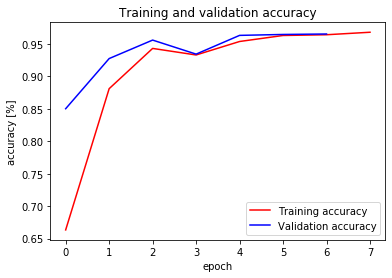

<Figure size 432x288 with 0 Axes>

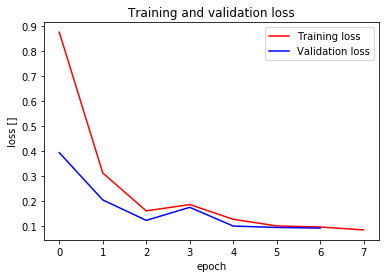

<Figure size 432x288 with 0 Axes>

In [15]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(len(acc))

plt.plot(np.arange(len(acc)), acc, 'r', label='Training accuracy')
plt.plot(np.arange(len(val_acc)), val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy [%]')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(np.arange(len(loss)), loss, 'r', label='Training loss')
plt.plot(np.arange(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss []')
plt.legend(loc=0)
plt.figure()
plt.show()

### F1 OF THE MODEL
Notice that the prediction is the average of x and reversed x. This improves F1.


In [68]:
def test_data(x,y,model):
    ## INPUTS
    #  x:data (3D)
    #  y:labels in one hot (3D)
    ## OUTPUTS
    #  accuracy
    #  F1
    #  y_pred flatenned
    y_pred=(model.predict(x)+model.predict(x[:,::-1,:])[:,::-1,:]).argmax(axis=2)
    y_real=y.argmax(axis=2)
    accuracy=(np.double(y_pred==y_real)).sum()/(y_pred.shape[0]*y_pred.shape[1])
    print("accuracy: %.4f" %accuracy)
    F1 = f1_score(y_real.reshape(-1,1), y_pred.reshape(-1,1), average="macro")
    print("F1 train: %.4f" %F1)
    return accuracy, F1, y_pred.reshape(-1,1)

accuracy_train, F1_train, y_pred_train = test_data(x_train,y_train,model)
accuracy_CV, F1_CV, y_pred_CV = test_data(x_CV,y_CV,model)


accuracy: 0.9659
F1 train: 0.9343
accuracy: 0.9665
F1 train: 0.9339


### ACCUMULATED ERROR

The figure shows the accumulated error to see where error is mainly produced.

The region with more errors are the ones with 10 channels, i.e. series 4 and 9.

accuracy: 0.9691
F1 train: 0.9394


Text(0.5, 0, 'time [$10^{-4} s$]')

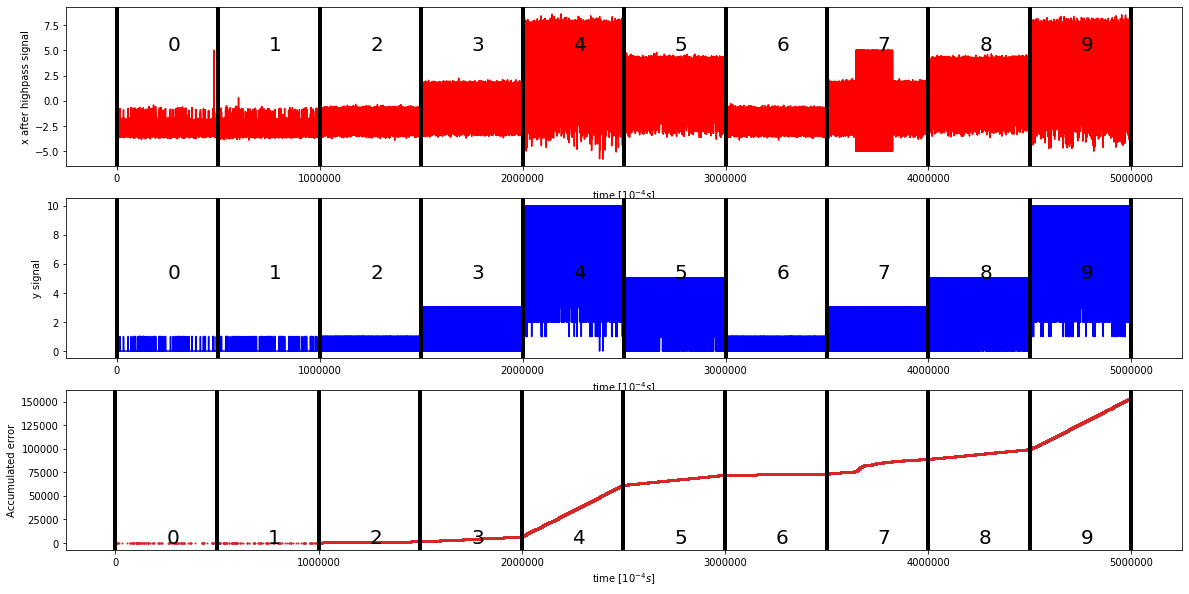

In [40]:
accuracy, F1, y_pred = test_data(xfft.reshape(-1,size,NCHANNELX),y.reshape(-1,size,11),model)
predicted_right=(y_pred==y_s)

t=np.arange(y_s.shape[0])

## y right predicted:
yg=y_pred[predicted_right.reshape(-1),0]
tg = t[predicted_right.reshape(-1)]

## y wrong predicted
yb = y_pred[False==predicted_right.reshape(-1),0]
tb = t[False==predicted_right.reshape(-1)]

## Initial data
xt=xfft.reshape(-1)
yt=y_s.reshape(-1)



plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(np.arange(xfft.shape[0]),xfft,color='red')
for i in range(10):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*10,linewidth=4, color='black')
plt.ylabel('x after highpass signal')
plt.xlabel('time [$10^{-4} s$]')
plt.subplot(312)
plt.plot(np.arange(y_s.shape[0]),y_s,color='blue')
for i in range(10):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*10,linewidth=4, color='black')
plt.ylabel('y signal')
plt.xlabel('time [$10^{-4} s$]')
plt.subplot(313)
plt.scatter(tb,np.arange(yb.shape[0]),color='tab:red',s=1)
for i in range(10):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*10,linewidth=4, color='black')
plt.ylabel('Accumulated error')
plt.xlabel('time [$10^{-4} s$]')
plt.show()

## TEST DATA

Shape of label matrix x is: (500,4000,1)


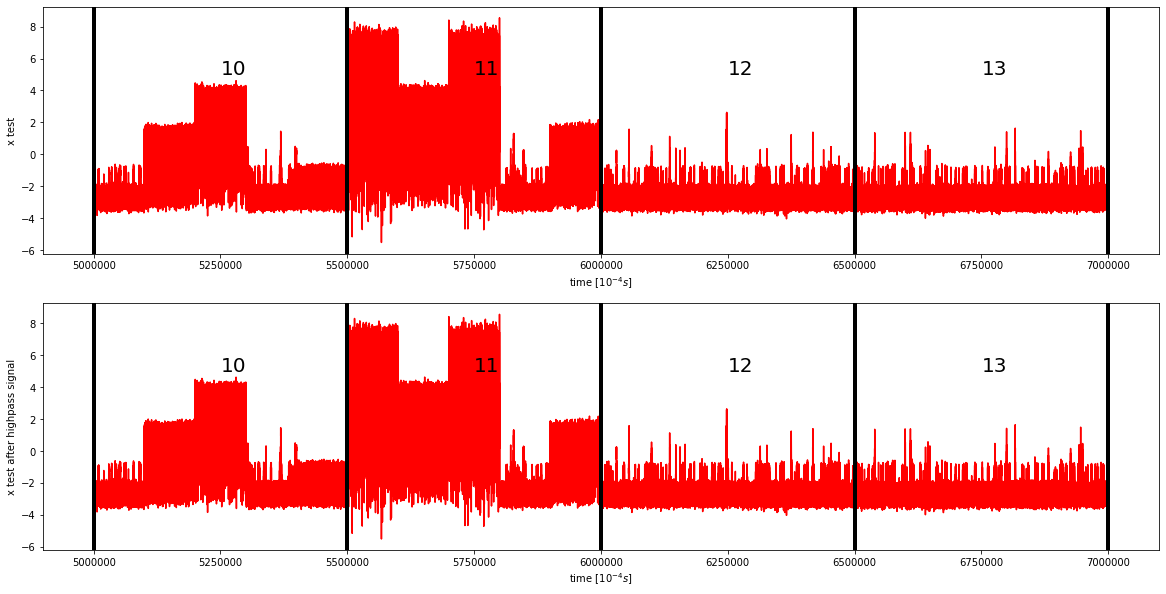

In [13]:
df = pd.read_csv(PATH_DATA+"test_clean.csv")  # Pre-cleaned data
#df = pd.read_csv(PATH_DATA+"test.csv")
x_test=np.array(df.iloc[:,1]).reshape(-1,1)
time=np.array(df.iloc[:,0])*1e4
del df

BATCHTEST=4
#x_test=HighPassfilter(x_test,HARMONICS,BATCHTEST,REMOVEBIAS)
x_test=x_test.reshape(-1,size,1)
print("Shape of label matrix x is: (%d,%d,%d)" %x_test.shape)


plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(time,x_test.reshape(-1,1),color='red')
for i in range(10,14):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*14,linewidth=4, color='black')
plt.ylabel('x test')
plt.xlabel('time [$10^{-4} s$]')

plt.subplot(212)
plt.plot(time,x_test.reshape(-1,1),color='red')
for i in range(10,14):
    plt.axvline(x=500000*i,linewidth=4, color='black')
    plt.text(500000*i+250000, 5, str(i), fontsize=20)
plt.axvline(x=500000*14,linewidth=4, color='black')
plt.ylabel('x test after highpass signal')
plt.xlabel('time [$10^{-4} s$]')

plt.show()

### SUBMISSION FILE

In [14]:
def test_data(x,model):
    ## INPUTS
    #  x:data (3D)
    #  model
    ## OUTPUT
    #  ya:
    cont=0
    xa=x
    ya=(model.predict(xa)+model.predict(xa[:,::-1,:])[:,::-1,:])   
    cont=cont+2
    for j in range(100):
        xa=x+np.random.rand(x.shape[0],x.shape[1],x.shape[2])*0.05
        ya=ya+(model.predict(xa)+model.predict(xa[:,::-1,:])[:,::-1,:])
        cont=cont+2
    ya=ya/cont
    return ya

In [16]:
## List of model to ensemble
ModelList = [#'CONV1D_LADDERNETINCEPTION4000_V20200420_DATACLEAN_nono.h5',
             #'CONV1D_LADDERNETRESNET4000_V20200420_DATACLEAN_nono.h5',
             'CONV1D_WAVENET4000_V20200420_DATACLEAN_nono_X1.h5',
             'CONV1D_WAVENET4000_V20200420_DATACLEAN_nono_X1_2.h5',
             'CONV1D_WAVENET4000_V20200421_DATACLEAN_nono_X1_1.h5',
             'CONV1D_WAVENET4000_V20200421_DATACLEAN_nono_X1_2.h5',
             'CONV1D_WAVENET4000_V20200421_DATACLEAN_nono_X1_3.h5',
              ] 

## Trained model folder
PATH_MODEL="Trained models/"

ylist=[]

cont=0
if len(ModelList)>0:
    for i in range(len(ModelList)):
        print('Loading model: ',ModelList[i])
        model=tf.keras.models.load_model(PATH_MODEL+ModelList[i])
        print('Predicting with model: ',ModelList[i])
        y_pred = test_data(x_test,model)
        cont=cont+1
        ylist.append(y_pred)
y_pred=ylist[0]
if len(ylist)>0:
    for i in range(1,len(ylist)):
        y_pred=y_pred+ylist[i]
y_pred=y_pred/cont
y_pred=y_pred.reshape(-1,11)

np.savetxt(PATH_RESULTS+'WAVENET_RESULTS_20200502.csv',y_pred)

Loading model:  CONV1D_WAVENET4000_V20200420_DATACLEAN_nono_X1.h5
Predicting with model:  CONV1D_WAVENET4000_V20200420_DATACLEAN_nono_X1.h5
Loading model:  CONV1D_WAVENET4000_V20200420_DATACLEAN_nono_X1_2.h5
Predicting with model:  CONV1D_WAVENET4000_V20200420_DATACLEAN_nono_X1_2.h5
Loading model:  CONV1D_WAVENET4000_V20200421_DATACLEAN_nono_X1_1.h5
Predicting with model:  CONV1D_WAVENET4000_V20200421_DATACLEAN_nono_X1_1.h5
Loading model:  CONV1D_WAVENET4000_V20200421_DATACLEAN_nono_X1_2.h5
Predicting with model:  CONV1D_WAVENET4000_V20200421_DATACLEAN_nono_X1_2.h5
Loading model:  CONV1D_WAVENET4000_V20200421_DATACLEAN_nono_X1_3.h5
Predicting with model:  CONV1D_WAVENET4000_V20200421_DATACLEAN_nono_X1_3.h5


In [17]:
result=['WAVENET_RESULTS_20200502.csv',
        'LGBM_RESULTS_20200502.csv',
        'CATBOOST_RESULTS_20200502_V2.csv',
        'CATBOOST_RESULTS_20200502.csv']
weights=[2,0,1,1]
ylist=[]
for file in result:
    y_pred=np.loadtxt(PATH_RESULTS+file)  
    ylist.append(y_pred)

for i in range(len(ylist)):
    y_pred=y_pred+ylist[i]*weights[i]

y_pred=y_pred.argmax(1).reshape(-1,1)


## Submission file
REC=np.hstack([time.reshape(-1,1)/1e4,y_pred])
# Save Numpy array to csv
np.savetxt('submission.csv', REC, delimiter=',', fmt='%.4f,%d',header ='time,open_channels',comments='')

print("submission file created")

submission file created
